/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
6.46 0.8552631578947368


<Quantity 277.69230769 mm>

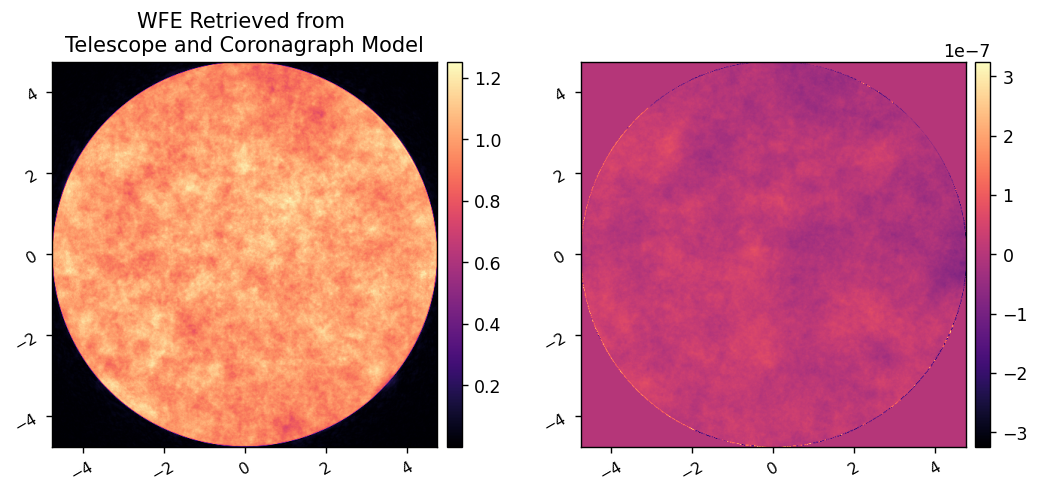

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_2dm as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils

from apra_pop_models.imshows import *

pupil_diam = 9.5*u.mm
wavelength_c = 650e-9*u.m

print(400/500*9.5 * 0.85, 6.5/ (400/500*9.5))

vortex = apra_pop_models.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

FN = 500
optimal_dm1_dm2 = (pupil_diam**2/(wavelength_c*FN)).to(u.mm)
display(optimal_dm1_dm2)

# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('../phase-retrieval-data/post_fpm_wfe_20240118.fits')
coro_wfe = wfe_fits[0].data
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1],
                                     pixelscale=wfe_pxscl,
                                     name='Total WFE')
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 
        'WFE Retrieved from \nTelescope and Coronagraph Model',
        pxscl=wfe_pxscl.to(u.mm/u.pix))

# reload(utils)
# wfe = utils.generate_wfe(diam=pupil_diam, npix=512, oversample=1,
#                          opd_index=2.75, amp_index=2.75, 
#                          opd_seed=123, amp_seed=1234,
#                          opd_rms=15*u.nm, amp_rms=0.05, 
#                          wavelength=wavelength_c)
# CORO_WFE = poppy.ArrayOpticalElement(name='WFE', 
#                                      transmission=xp.abs(wfe),
#                                      opd=xp.angle(wfe)*wavelength_c.to_value(u.m)/(2*np.pi), 
#                                      pixelscale=pupil_diam/(512*u.pix),)

# wfe_mask = CORO_WFE.amplitude>0
# rms_amp = xp.sqrt(xp.mean(CORO_WFE.amplitude[wfe_mask]**2))
# rms_opd = xp.sqrt(xp.mean(CORO_WFE.opd[wfe_mask]**2))
# imshow2(CORO_WFE.amplitude, CORO_WFE.opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

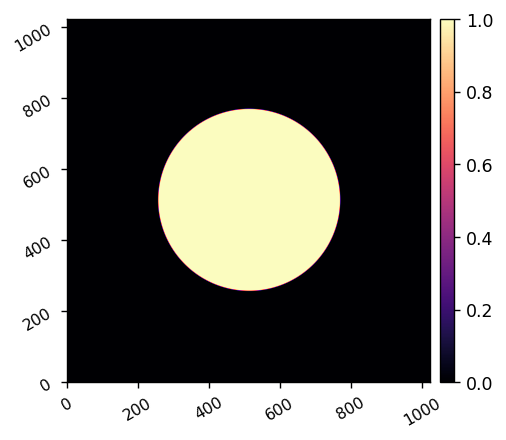

In [7]:
fwf = poppy.FresnelWavefront(beam_radius=10*u.mm, wavelength=wavelength_c, npix=512, oversample=2)
pupil = poppy.CircularAperture(radius=10*u.mm, ).get_transmission(fwf)
imshow1(pupil)

In [8]:
fwf.pixelscale

<Quantity 3.90625e-05 m / pix>

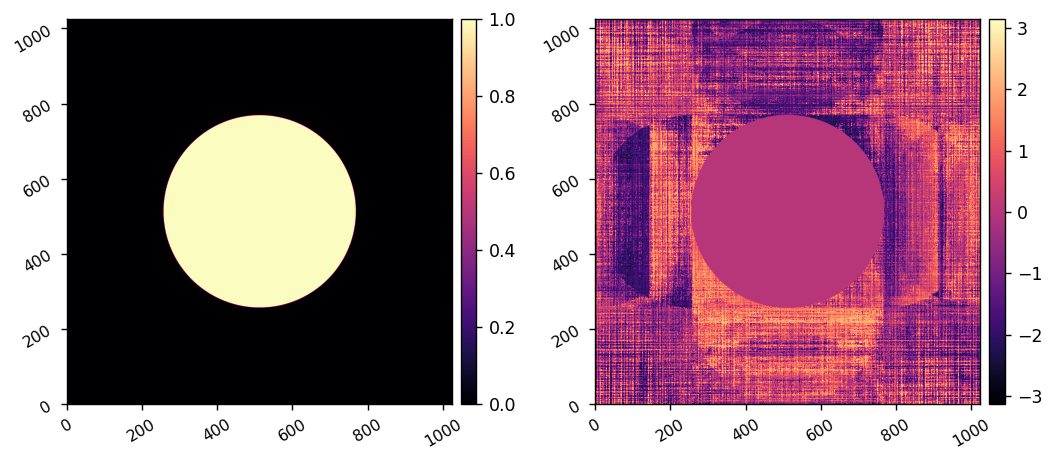

In [15]:
reload(fraunhofer)
prop_wf = fraunhofer.angular_spectrum(pupil, wavelength_c, distance=1000*u.mm, pixelscale=fwf.pixelscale)
prop_wf = fraunhofer.angular_spectrum(prop_wf, wavelength_c, distance=-1000*u.mm, pixelscale=fwf.pixelscale)
imshow2(xp.abs(prop_wf), xp.angle(prop_wf))

Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


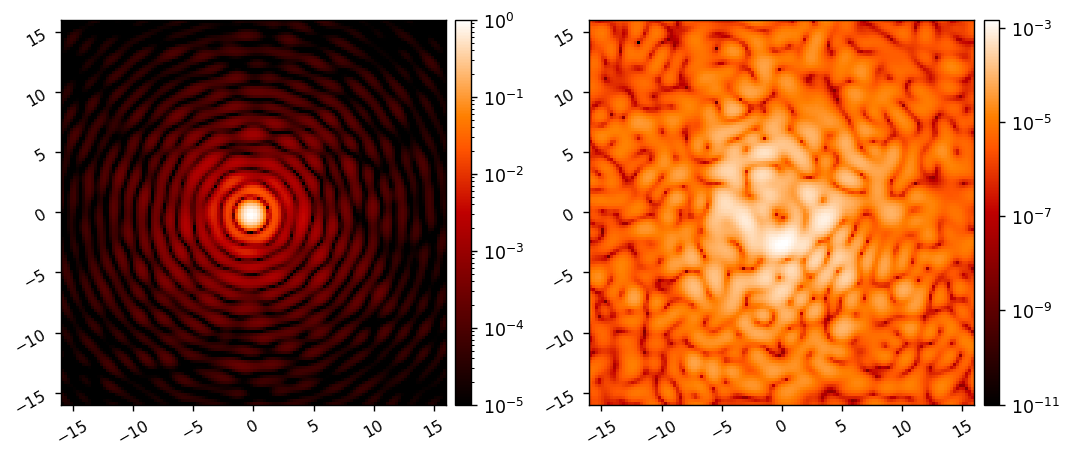

In [2]:
reload(fraunhofer)
model = fraunhofer.CORO(npix=512, oversample=16, npsf=128,
                        RETRIEVED=CORO_WFE,
                       )
model.reverse_parity = True
psf = model.snap()
model.Imax_ref = xp.max(psf)

ref_psf = model.snap()

vortex_phasor = fraunhofer.make_vortex_phase_mask(model.N, 
                                                  # singularity=400*u.um,
                                                  focal_length=500*u.mm, pupil_diam=model.pupil_diam, 
                                                  wavelength=model.wavelength_c)
model.FPM = vortex_phasor
ref_im = model.snap()

imshow2(ref_psf, ref_im, pxscl=model.psf_pixelscale_lamD,
        lognorm=True, vmin1=1e-5, vmin2=1e-11, 
        cmap1='gist_heat', cmap2='gist_heat')

Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


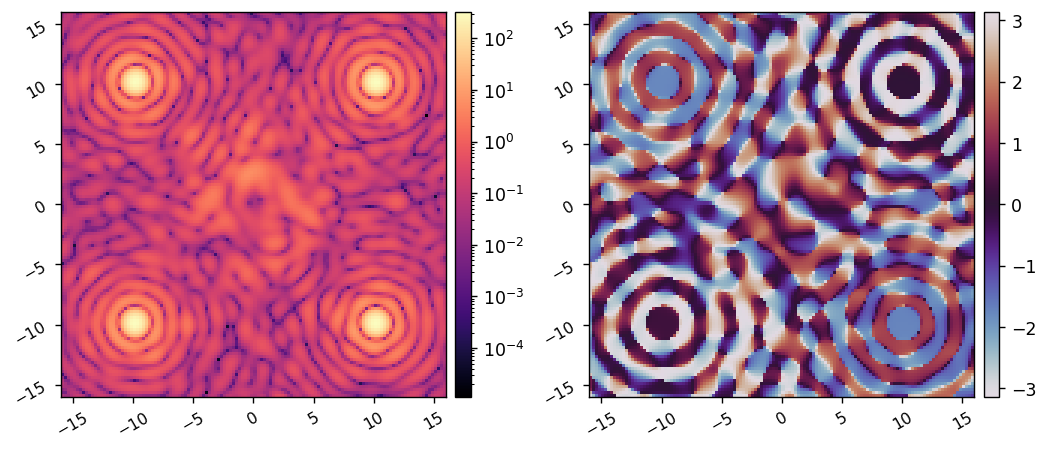

In [4]:
import scoobpsf
reload(apra_pop_models.dm)
reload(fraunhofer)
model = fraunhofer.CORO(npix=512, oversample=16, npsf=128,
                        use_lyot_stop=True,
                        RETRIEVED=CORO_WFE, 
                        )

pup_ratio = model.pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-8
separation = 10
comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)

model.set_dm1(ensure_np_array(comm1))
model.set_dm2(ensure_np_array(comm2))

vortex_phasor = fraunhofer.make_vortex_phase_mask(model.N, 
                                                  # singularity=400*u.um,
                                                  focal_length=500*u.mm, pupil_diam=model.pupil_diam, 
                                                  wavelength=model.wavelength_c)
model.FPM = vortex_phasor

wfs = model.calc_wfs()
imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True, pxscl=model.psf_pixelscale_lamD, cmap2='twilight')

0.00475 m 109.04951422556877 m


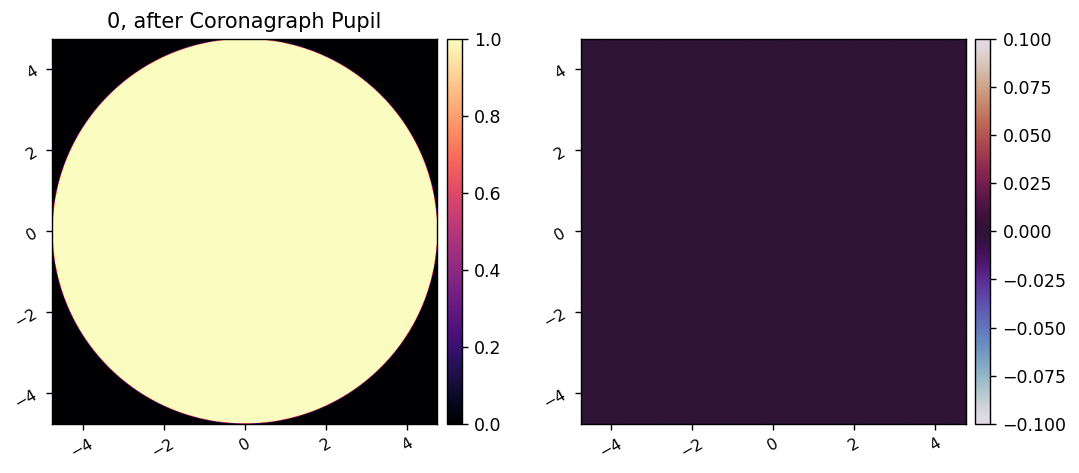

0.00475 m 109.04951422556877 m


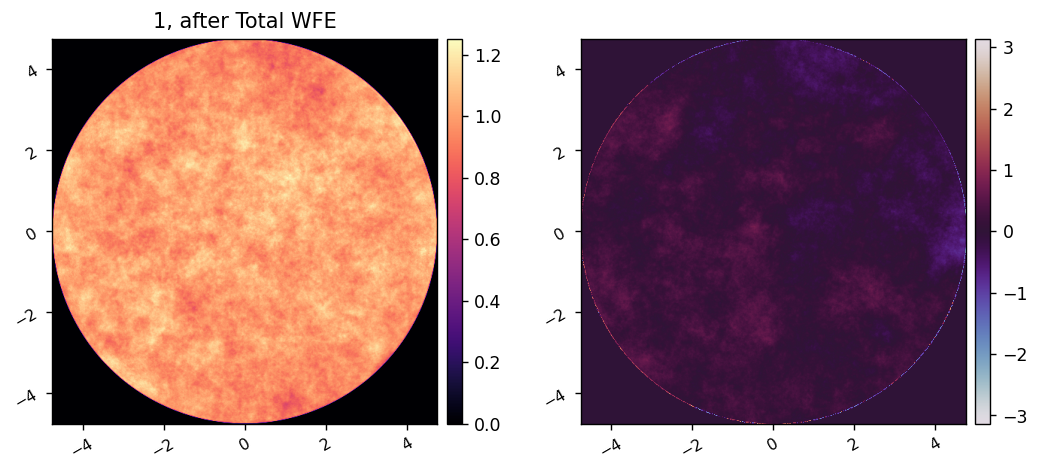

0.00475 m 109.04951422556877 m


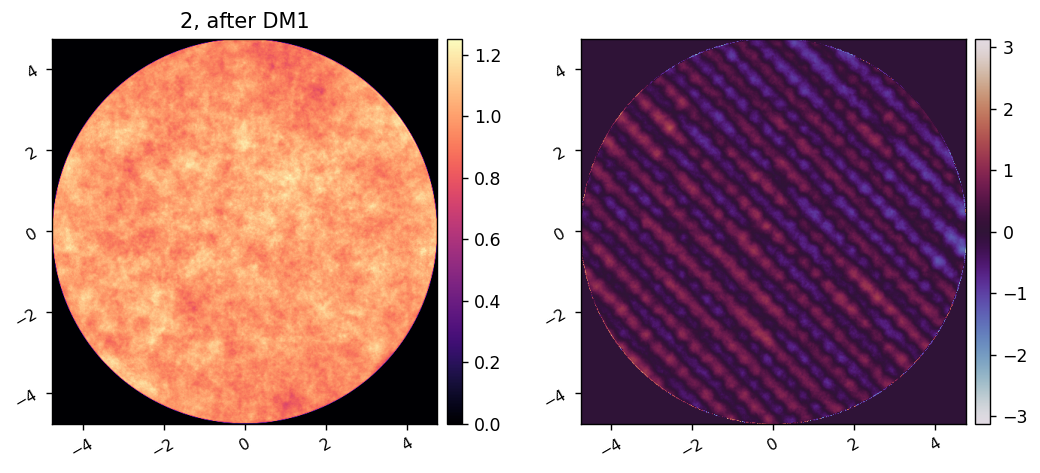

0.00475 m 109.04951422556877 m


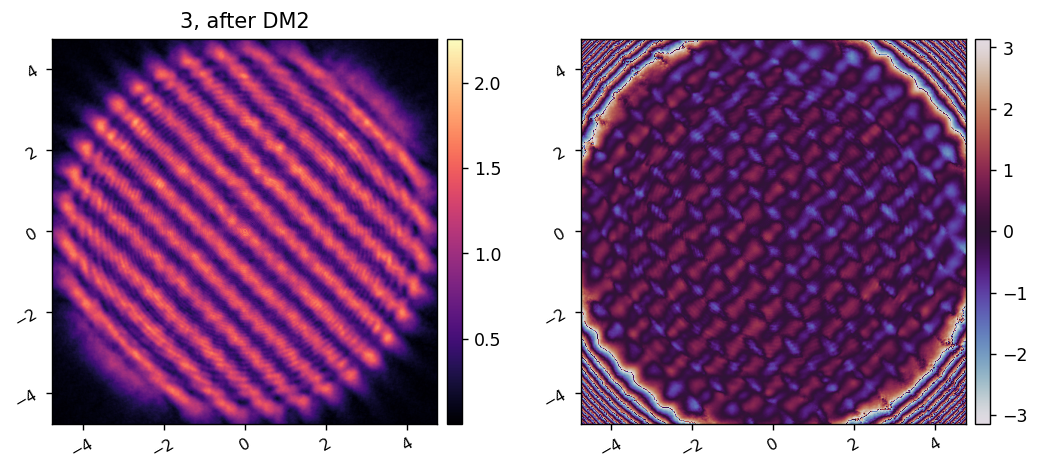

0.00475 m 109.04951422556877 m


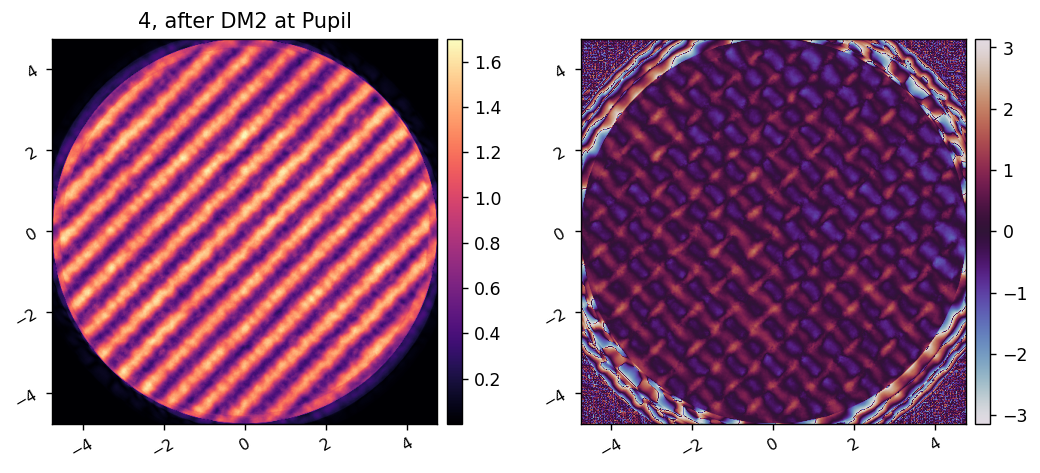

0.00475 m 109.04951422556877 m


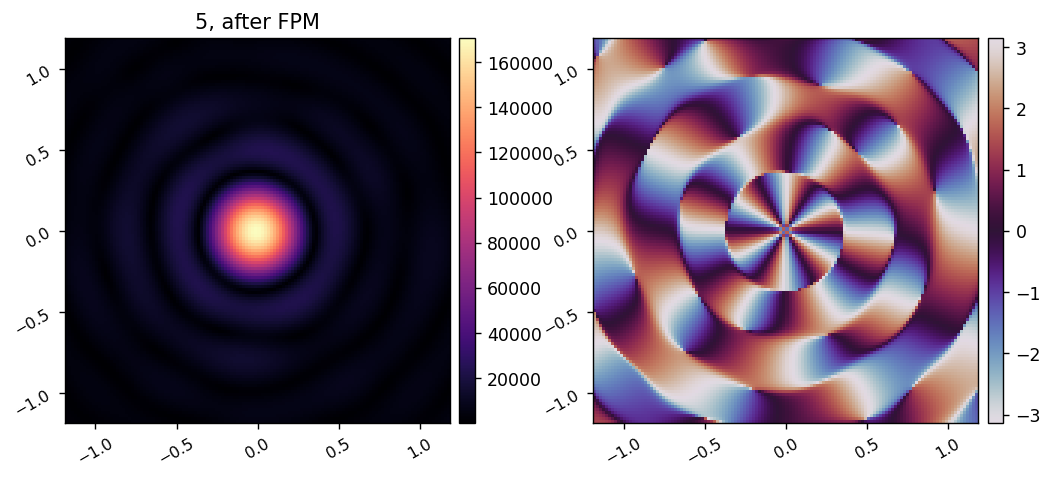

0.00475 m 109.04951422556877 m


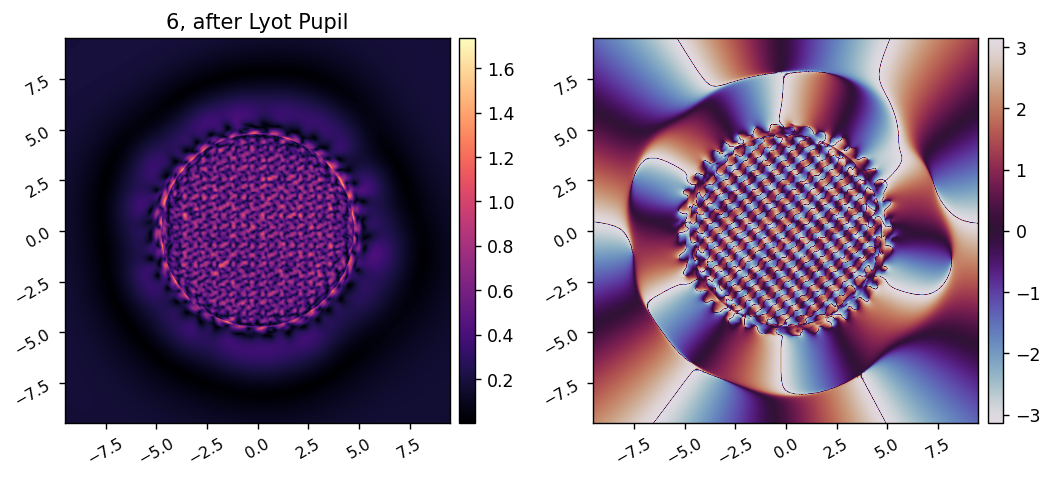

0.00475 m 109.04951422556877 m


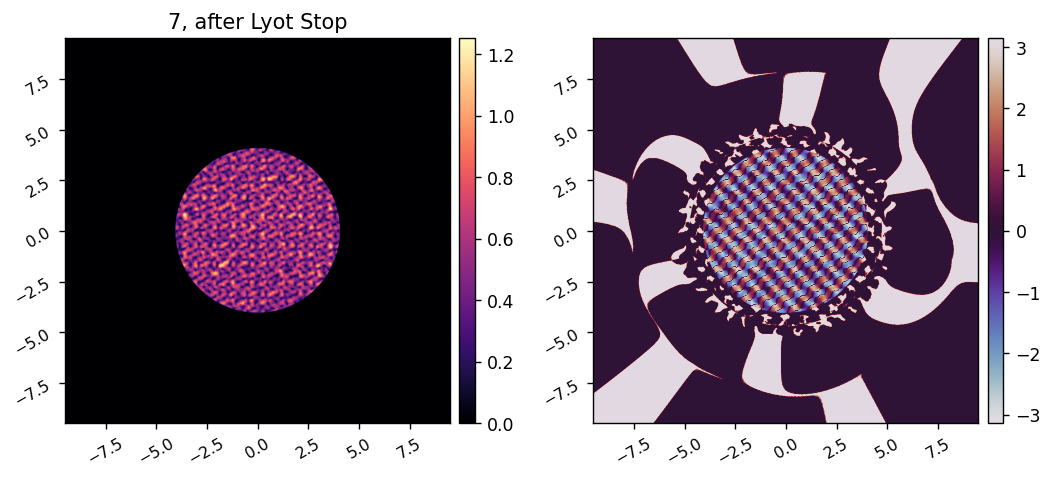

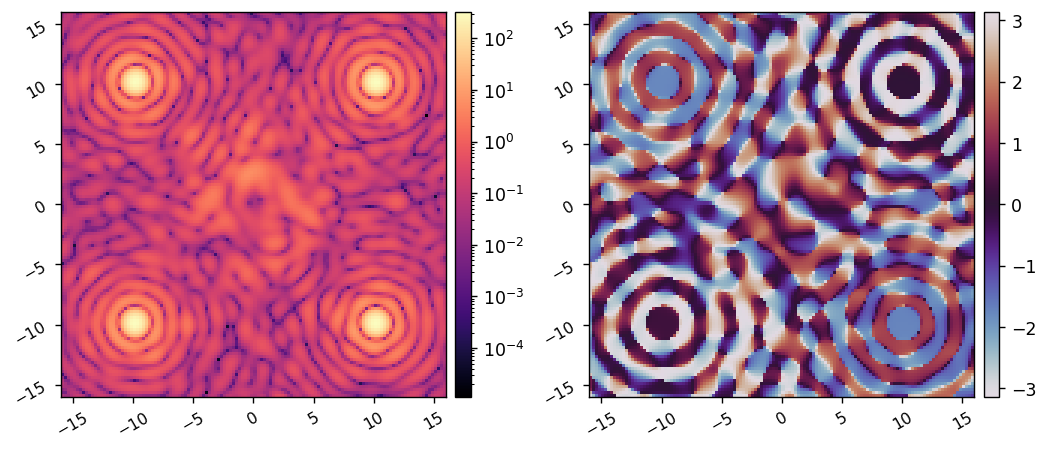

In [12]:
for i,wf in enumerate(wfs[:-1]):
    if 'FPM' in wf.location:
        npix=128
    elif 'Lyot' in wf.location:
        npix=2*model.npix
    else:
        npix=model.npix
    print(wf.w_0, wf.z_r)
    imshow2(wf.amplitude, wf.phase, f'{i:d}, '+wf.location, 
            npix=npix, pxscl=wf.pixelscale.to(u.mm/u.pix),
            cmap1='magma', cmap2='twilight')

imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True, pxscl=model.psf_pixelscale_lamD, cmap2='twilight')

In [ ]:
for i,wf in enumerate(wfs[:-1]):
    if 'FPM' in wf.location:
        npix=128
    elif 'Lyot' in wf.location:
        npix=2*model.npix
    else:
        npix=model.npix
    print(wf.w_0, wf.z_r)
    imshow2(wf.amplitude, wf.phase, f'{i:d}, '+wf.location, 
            npix=npix, pxscl=wf.pixelscale.to(u.mm/u.pix),
            cmap1='magma', cmap2='twilight')

imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True, pxscl=model.psf_pixelscale_lamD, cmap2='twilight')

In [ ]:
reload(fraunhofer)
model = fraunhofer.CORO(npix=512, oversample=8,
                        pupil_diam=9.5*u.mm,
                        RETRIEVED=CORO_WFE, 
                        )

fpwf = model.calc_psf()
imshow2(xp.abs(fpwf)**2, xp.angle(fpwf), lognorm1=True, pxscl=model.psf_pixelscale_lamD, cmap2='twilight')